# Example SFH

The configuration of `pymiles` can be changed either from a configuration file or directly with environent variables.
The most important one is to define in which **pre-existing** folder the repository are located.

Do not worry! If it can not find the hdf5 files, it will try to download them automatically.

In [1]:
import os
os.environ['PYMILES_REPOSITORY_FOLDER'] = '/tmp/'

In [2]:
from pymiles import SFH
import matplotlib.pyplot as plt

## Initialize

Generate the base sfh object, which then can be modified to obtain the desired star formation history and the associated spectra.

In [3]:
sfh = SFH(
        source="MILES_SSP",
        version="9.1",
        imf_type="bi",
        isochrone="T",
)

## Configure
* Select the age range we want

In [4]:
sfh.set_time_range(start=13.5, end=0.01)

* Define the SFR

In [5]:
sfh.tau_sfr(start=11, tau=1.5, met=0.1)

* Metallicity evolution

In [6]:
sfh.met_evol_sigmoid(start=-2.1, end=0.2, tc=10, gamma=2.0)

* [alpha/Fe] evolution

In [7]:
sfh.alp_evol_sigmoid(start=0.4, end=0.0, tc=10)

* IMF evolution

In [8]:
sfh.imf_evol_linear(start=0.5, end=2.3, t_start=11.5, t_end=9.0)

## Explore the SFH

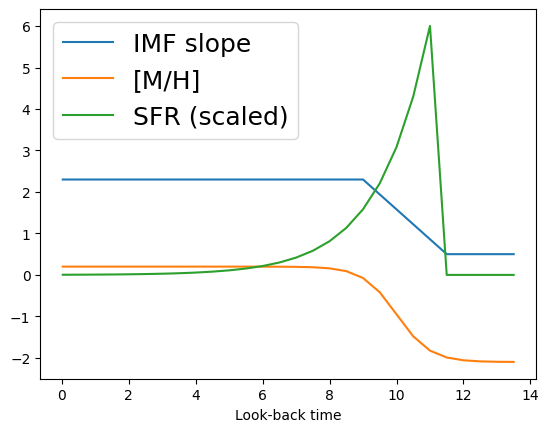

In [9]:
plt.plot(sfh.time, sfh.imf_evol, label="IMF slope")
plt.plot(sfh.time, sfh.met_evol, label="[M/H]")
plt.plot(sfh.time, sfh.sfr * 10, label="SFR (scaled)")
plt.xlabel("Look-back time")
plt.legend(fontsize=18)

## Generate the predictions

In [10]:
pred = sfh.generate_spectra()

## Explore the results

In [11]:
import pymiles.filter as flib
filts = flib.get( flib.search("sloan") )
outmls = pred.mass_to_light(filters=filts, mass_in="star+remn")
print("Mass-weighted age", pred.age)
print("Mass-weighted [M/H]", pred.met)
print("M/L g-band", outmls["SLOAN_SDSS.g"])

pymiles.magnitudes: Filter SLOAN_SDSS.i [6430.0,8630.0] is outside ofthe spectral range [3540.5, 7409.6]
pymiles.magnitudes: Filter SLOAN_SDSS.u [2980.0,4130.0] is outside ofthe spectral range [3540.5, 7409.6]
pymiles.magnitudes: Filter SLOAN_SDSS.z [7730.0,11230.0] is outside ofthe spectral range [3540.5, 7409.6]


Mass-weighted age 9.747229444806024
Mass-weighted [M/H] -0.9777525480919624
M/L g-band [3.01242965]


And also the associated spectra

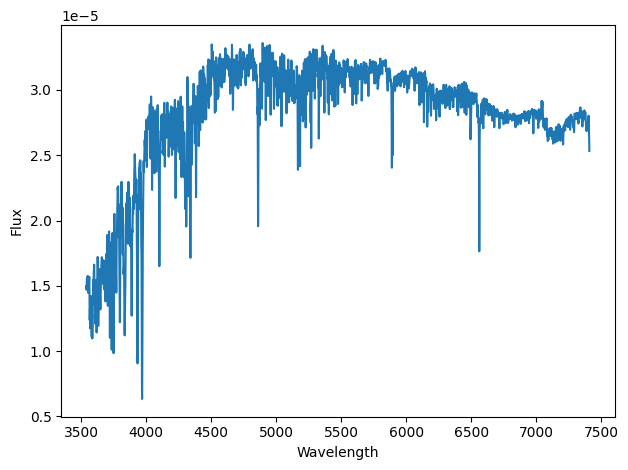

In [12]:
plt.plot(pred.spectral_axis, pred.flux)
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.tight_layout()
plt.show()